In [1]:
#import libraries
import re, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [2]:
#set the style
sns.set(style = "whitegrid")
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\пк\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
APP_ID = "com.linkedin.android"       #LinkedIn app
LANG = "en"                           #set the language of reviews to English (universal)
COUNTRIES = ["us", "gb", "it", "fi", "kz"]   #set the countries to US, UK, Italy, Finland, Kazakhstan
MAX_REVIEWS_PER_COUNTRY = 2000        #set the maximum number of reviews per country

#load the data
df = pd.read_csv("linkedin_reviews_raw.csv")

In [4]:
#clean text
def clean(text):
    if not isinstance(text, str): return ""
    text = re.sub(r"http\S+|www\S+"," ", text)
    text = re.sub(r"[^A-Za-z0-9 .,!?'’]"," ", text)
    text = re.sub(r"\s+"," ", text).strip()
    return text

df["review_clean"] = df["review"].apply(clean)

#VADER sentiment
sia = SentimentIntensityAnalyzer()
scores = df["review_clean"].apply(sia.polarity_scores).apply(pd.Series)
df = pd.concat([df, scores], axis = 1)

df["sentiment_vader"] = pd.cut(
    df["compound"],
    bins = [-1.01, -0.05, 0.05, 1.01],
    labels = ["negative", "neutral", "positive"]
)

#save
df.to_csv("linkedin_reviews_clean.csv", index = False)

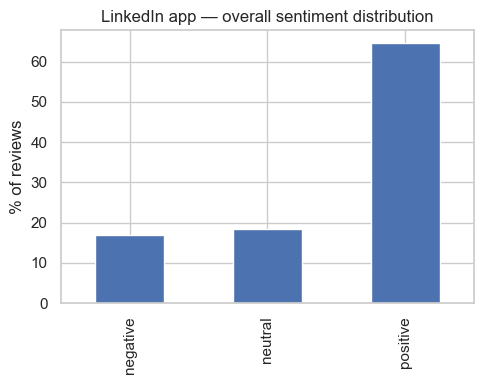

C:\Users\пк\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\пк\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)
C:\Users\пк\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group i

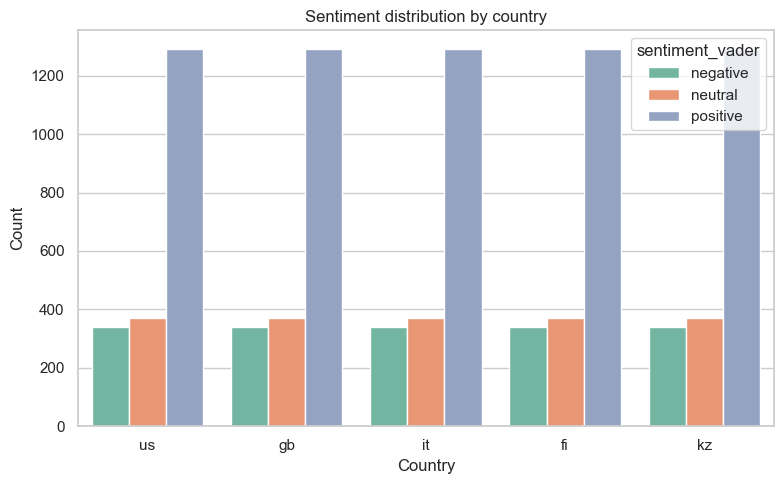

In [5]:
#visualizations

#overall sentiment distribution
plt.figure(figsize = (5, 4))
(df["sentiment_vader"].value_counts(normalize = True)
   .reindex(["negative", "neutral", "positive"])
   .mul(100).plot(kind = "bar"))
plt.title("LinkedIn app — overall sentiment distribution")
plt.ylabel("% of reviews"); plt.xlabel("")
plt.tight_layout(); plt.savefig("images/sentiment_distribution.png", dpi = 300)
plt.show()

#sentiment distribution per country
plt.figure(figsize = (8, 5))
sns.countplot(data = df, x = "country", hue = "sentiment_vader", order = COUNTRIES, palette = "Set2")
plt.title("Sentiment distribution by country")
plt.xlabel("Country"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig("images/sentiment_dist_by_country.png", dpi = 300)
plt.show()